In [1]:
import math
import random
import matplotlib.pyplot as plt
from dataclasses import dataclass
import tensorflow as tf
from keras import models
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Softmax, BatchNormalization, Add, Activation, AveragePooling2D, GlobalAveragePooling2D, Concatenate
from IPython.display import SVG
import pydot
import graphviz
from tensorflow.keras.utils import model_to_dot


# Part 1

In [2]:
def f(x, y):
    return x**2 + y**2 + x*(y + 2) + math.cos(3*x)

def dfdx(x, y):
    return 2*x + y + 2 - 3*math.sin(3*x)

def dfdy(x, y):
    return 2*y + x

In [3]:
@dataclass
class GDPoint():
    x: int
    y: int
    z: int

In [4]:
def gradient_descent(x, y, lr, steps=20):
    data_points = []
    for _ in range(steps):
        z = f(x, y)
        data_points.append(GDPoint(x, y, z))
        dx = dfdx(x, y)
        dy = dfdy(x, y)
        x -= dx * lr
        y -= dy * lr
    return x, y, data_points

In [5]:
results =  []
for x_init in range(-10, 10):
    for y_init in range(-10, 10):
        x_final, y_final, values = gradient_descent(x_init, y_init, 0.1, 100)
        results.append(values)

x_final=-1.0881624094117672, y_final=0.5440812010518068, values[-1]=GDPoint(x=-1.088162409312122, y=0.5440812001507432, z=-2.280709708147053)


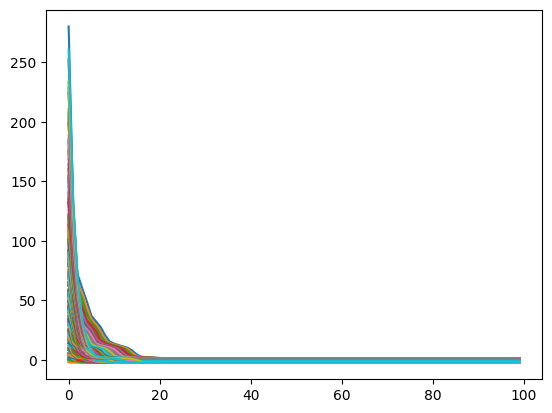

In [6]:
print(f'{x_final=}, {y_final=}, {values[-1]=}')
fig = plt.figure()
ax = fig.add_subplot()
for result in results:
    zs = [d.z for d in result]
    ax.plot(zs)


# Part 2

In [78]:
def getVGG16():
    inputs = Input(shape=(32, 32, 3))
    conv1 = Conv2D(64, kernel_size=3, padding='same', activation='relu')(inputs)
    conv2 = Conv2D(64, kernel_size=3, padding='same', activation='relu')(conv1)
    maxpool1 = MaxPooling2D(pool_size=2, strides=2, padding='same')(conv2)
    conv3 = Conv2D(128, kernel_size=3, padding='same', activation='relu')(maxpool1)
    conv4 = Conv2D(128, kernel_size=3, padding='same', activation='relu')(conv3)
    maxpool2 = MaxPooling2D(pool_size=2, strides=2, padding='same')(conv4)
    conv5 = Conv2D(256, kernel_size=3, padding='same', activation='relu')(maxpool2)
    conv6 = Conv2D(256, kernel_size=3, padding='same', activation='relu')(conv5)
    conv7 = Conv2D(256, kernel_size=3, padding='same', activation='relu')(conv6)
    conv8 = Conv2D(256, kernel_size=3, padding='same', activation='relu')(conv7)
    maxpool3 = MaxPooling2D(pool_size=2, strides=2, padding='same')(conv8)
    conv9 = Conv2D(512, kernel_size=3, padding='same', activation='relu')(maxpool3)
    conv10 = Conv2D(512, kernel_size=3, padding='same', activation='relu')(conv9)
    conv11 = Conv2D(512, kernel_size=3, padding='same', activation='relu')(conv10)
    conv12 = Conv2D(512, kernel_size=3, padding='same', activation='relu')(conv11)
    maxpool4 = MaxPooling2D(pool_size=2, strides=2, padding='same')(conv12)
    conv13 = Conv2D(512, kernel_size=3, padding='same', activation='relu')(maxpool4)
    conv14 = Conv2D(512, kernel_size=3, padding='same', activation='relu')(conv13)
    conv15 = Conv2D(512, kernel_size=3, padding='same', activation='relu')(conv14)
    conv16 = Conv2D(512, kernel_size=3, padding='same', activation='relu')(conv15)
    maxpool5 = MaxPooling2D(pool_size=2, strides=2, padding='same')(conv16)
    flatten = Flatten()(maxpool5)
    dense1 = Dense(4096, activation='relu')(flatten)
    dense2 = Dense(4096, activation='relu')(dense1)
    dense3 = Dense(10, activation='softmax')(dense2)

    model = models.Model(
        inputs=inputs,
        outputs=dense3
    )
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])
    return model

In [8]:
#  https://towardsdatascience.com/understand-and-implement-resnet-50-with-tensorflow-2-0-1190b9b52691
def resnetIdentity(x, filters):
    x_skip = x
    f1, f2 = filters
    x = Conv2D(f1, kernel_size=1, padding='valid', activation='relu')(x)
    x = Conv2D(f1, kernel_size=3, padding='same', activation='relu')(x)
    x = Conv2D(f2, kernel_size=1, padding='valid')(x)
    x = Add()([x, x_skip])
    x = Activation(tf.keras.activations.relu)(x)
    return x

def resnetConv(x, s, filters):
    x_skip = x
    f1, f2 = filters
    x = Conv2D(f1, kernel_size=1, strides=s, padding='valid', activation='relu')(x)
    x = Conv2D(f1, kernel_size=3, padding='same', activation='relu')(x)
    x = Conv2D(f2, kernel_size=1, padding='valid')(x)
    x_skip = Conv2D(f2, kernel_size=1, strides=s, padding='valid')(x_skip)
    x = Add()([x, x_skip])
    x = Activation(tf.keras.activations.relu)(x)
    return x

def getResnet50():
    inp = Input(shape=(32, 32, 3))
    x = Conv2D(64, kernel_size=7, strides=2, padding='same', activation='relu')(inp)
    x = MaxPooling2D(pool_size=3, strides=2)(x)
    x = resnetConv(x, s=1, filters=(64,256))
    x = resnetIdentity(x, filters=(64,256))
    x = resnetIdentity(x, filters=(64,256))
    
    x = resnetConv(x, s=2, filters=(128, 512))
    x = resnetIdentity(x, filters=(128, 512))
    x = resnetIdentity(x, filters=(128, 512))
    x = resnetIdentity(x, filters=(128, 512))
    
    x = resnetConv(x, s=2, filters=(256, 1024))
    x = resnetIdentity(x, filters=(256, 1024))
    x = resnetIdentity(x, filters=(256, 1024))
    x = resnetIdentity(x, filters=(256, 1024))
    x = resnetIdentity(x, filters=(256, 1024))
    x = resnetIdentity(x, filters=(256, 1024))
    
    x = resnetConv(x, s=2, filters=(512, 2048))
    x = resnetIdentity(x, filters=(512, 2048))
    x = resnetIdentity(x, filters=(512, 2048))
    
    x = AveragePooling2D(pool_size=2, padding='same')(x)
    x = Flatten()(x)
    x = Dense(10, activation='softmax')(x)
    
    model = models.Model(
        inputs=inp,
        outputs=x
    )
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])
    return model

In [9]:
#  https://towardsdatascience.com/creating-densenet-121-with-tensorflow-edbc08a956d8
def denseBlock(x, repetitions):
    for _ in range(repetitions):
        y = Conv2D(128, kernel_size=1, strides=1, padding='same', activation='relu')(x)
        y = Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(y)
        x = Concatenate()((y, x))
    return x

def getDenseNet():
    inp = Input(shape=(32, 32, 3))
    x = Conv2D(64, kernel_size=7, strides=2, padding='same', activation='relu')(inp)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    
    x = denseBlock(x, 6)
    
    x = Conv2D(128, kernel_size=1, strides=1, padding='same', activation='relu')(x)
    x = AveragePooling2D(pool_size=2, strides=2, padding='same')(x)
    
    x = denseBlock(x, 12)
    
    x = Conv2D(256, kernel_size=1, strides=1, padding='same', activation='relu')(x)
    x = AveragePooling2D(pool_size=2, strides=2, padding='same')(x)
    
    x = denseBlock(x, 24)
    
    x = Conv2D(512, kernel_size=1, strides=1, padding='same', activation='relu')(x)
    x = AveragePooling2D(pool_size=2, strides=2, padding='same')(x)
    
    x = denseBlock(x, 16)
    
    x = GlobalAveragePooling2D()(x)
    out = Dense(10, activation='softmax')(x)
    
    model = models.Model(
        inputs=inp,
        outputs=out
    )
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])
    return model

In [40]:
def mlpconvLayer(x):
    x = Conv2D(192, kernel_size=3, padding='same', activation='relu')(x)
    x = Conv2D(192, kernel_size=1, padding='same', activation='relu')(x)
    x = Conv2D(192, kernel_size=1, padding='same', activation='relu')(x)
    return x

def getNiN():
    inp = Input(shape=(32, 32, 3))
    x = Conv2D(128, kernel_size=3, padding='same', activation='relu')(inp)
    
    x = mlpconvLayer(x)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    x = mlpconvLayer(x)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    x = mlpconvLayer(x)
    
    x = Conv2D(10, kernel_size=1, activation='softmax')(x)
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = Softmax()(x)
    
    model = models.Model(
        inputs=inp,
        outputs=x
    )
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])
    return model

In [79]:
vgg16 = getVGG16()
vgg16.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_412 (Conv2D)         (None, 32, 32, 64)        1792      
                                                                 
 conv2d_413 (Conv2D)         (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_414 (Conv2D)         (None, 16, 16, 128)       73856     
                                                                 
 conv2d_415 (Conv2D)         (None, 16, 16, 128)       147584    
                                                           

In [20]:
resnet50 = getResnet50()
resnet50.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_205 (Conv2D)            (None, 16, 16, 64)   9472        ['input_5[0][0]']                
                                                                                                  
 max_pooling2d_12 (MaxPooling2D  (None, 7, 7, 64)    0           ['conv2d_205[0][0]']             
 )                                                                                                
                                                                                                  
 conv2d_206 (Conv2D)            (None, 7, 7, 64)     4160        ['max_pooling2d_12[0][0]'] 

In [21]:
denseNet = getDenseNet()
denseNet.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_258 (Conv2D)            (None, 16, 16, 64)   9472        ['input_6[0][0]']                
                                                                                                  
 max_pooling2d_13 (MaxPooling2D  (None, 8, 8, 64)    0           ['conv2d_258[0][0]']             
 )                                                                                                
                                                                                                  
 conv2d_259 (Conv2D)            (None, 8, 8, 128)    8320        ['max_pooling2d_13[0][0]'] 

In [41]:
NiN = getNiN()
NiN.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_401 (Conv2D)         (None, 32, 32, 128)       3584      
                                                                 
 conv2d_402 (Conv2D)         (None, 32, 32, 192)       221376    
                                                                 
 conv2d_403 (Conv2D)         (None, 32, 32, 192)       37056     
                                                                 
 conv2d_404 (Conv2D)         (None, 32, 32, 192)       37056     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 16, 16, 192)      0         
 g2D)                                                            
                                                           

In [28]:
def plotModel(model):
    return SVG(model_to_dot(
        model, show_shapes=True, show_layer_activations=True, rankdir='TB',
        expand_nested=False, dpi=60, subgraph=False
    ).create(prog='dot',format='svg'))

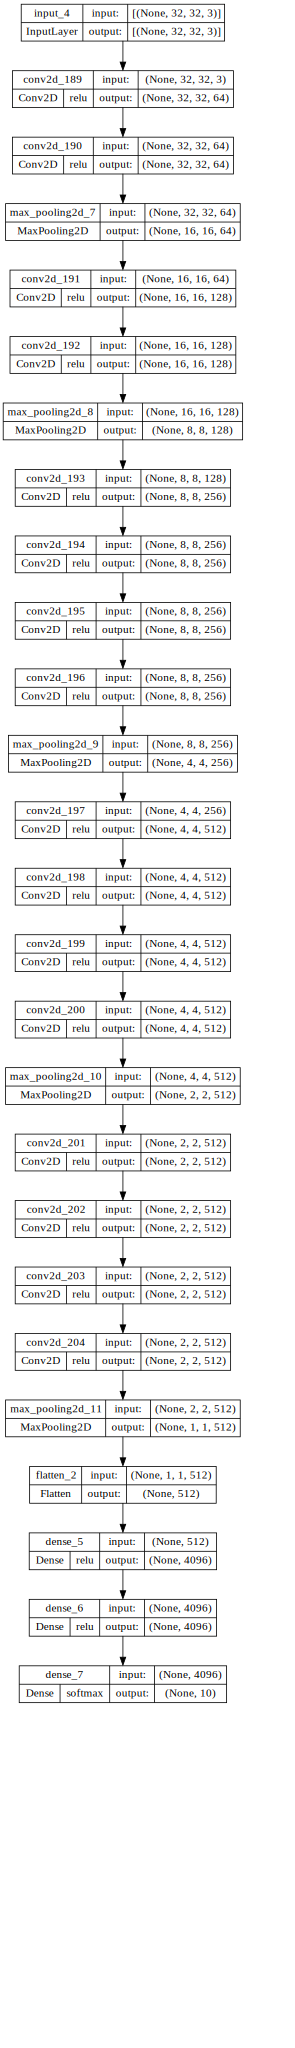

In [29]:
plotModel(vgg16)

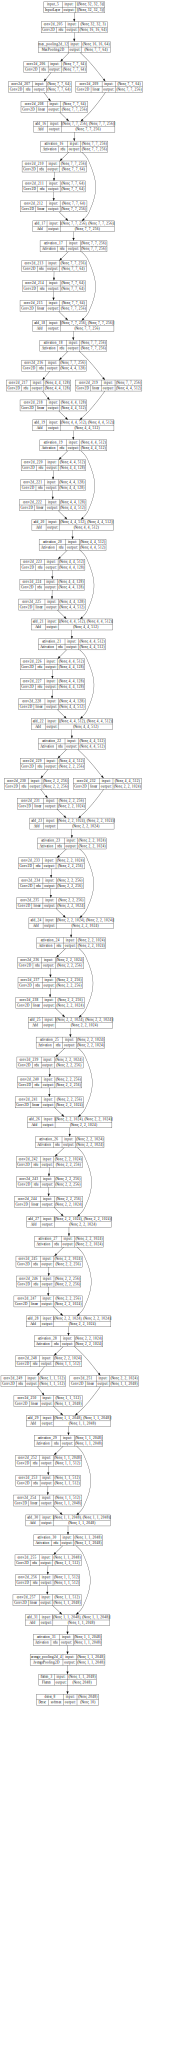

In [30]:
plotModel(resnet50)

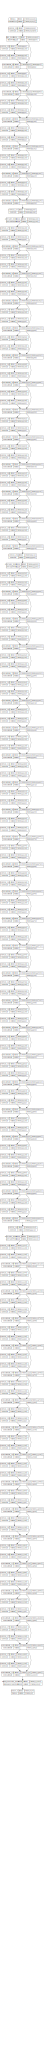

In [26]:
plotModel(denseNet)

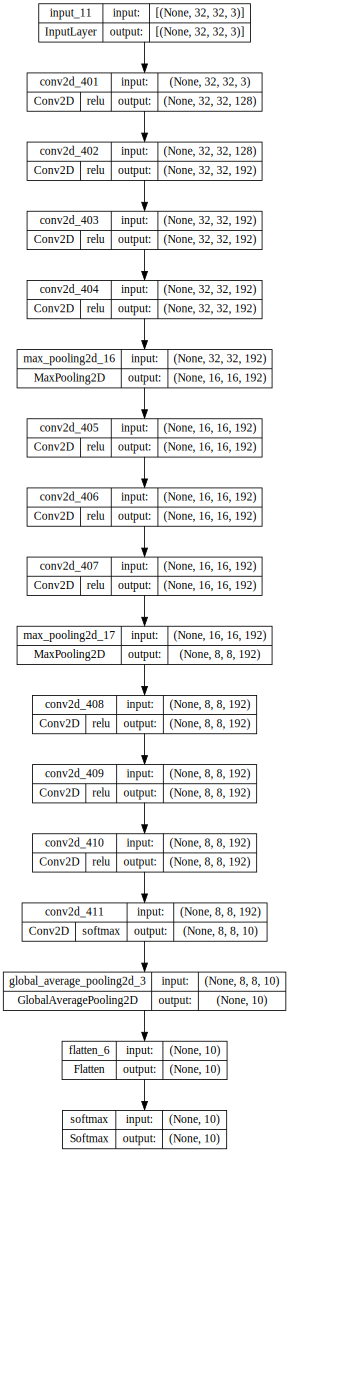

In [42]:
plotModel(NiN)

In [63]:
#  https://www.kaggle.com/code/nislambd/handwritten-digit-recognition-with-vgg19-and-dida
from keras.utils import load_img, img_to_array
import os
from tqdm import tqdm
import numpy as np

def image_files(input_directory):
    filepaths=[]
    labels=[]
    
    digit_folders=os.listdir(input_directory)
    #print(digit_folders)
    
    for digit in digit_folders:
        if digit == '.gitignore':
            continue
        path=os.path.join(input_directory, digit)
        flist=os.listdir(path)
        for f in flist:
            fpath=os.path.join(path,f)        
            filepaths.append(fpath)
            labels.append(digit) 
    return filepaths,labels

def load_images(filepaths):
    images = []
    for i in tqdm(range(len(filepaths))):
        img = load_img(filepaths[i], target_size=(32,32,3), grayscale=False)
        img = img_to_array(img)
        img.astype('float32')
        img = img/255
        images.append(img)

    images = np.array(images)
    return images

In [64]:
directory = '250000_Final'
filepaths, labels = image_files(directory)
images = load_images(filepaths)

100%|██████████| 252860/252860 [02:55<00:00, 1440.62it/s]


In [71]:
labels = np.array(labels)
labels = labels.astype('int32')
labels

array([0, 0, 0, ..., 9, 9, 9])

In [75]:
from keras.utils.np_utils import to_categorical
labels = to_categorical(labels, 10)
labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [76]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(images, labels, train_size=0.8, random_state=42, stratify=labels)

In [80]:
vgg16_history = vgg16.fit(x_train, y_train, epochs=100, batch_size=1024, validation_data=(x_test, y_test), verbose=1)

Epoch 1/100
  2/198 [..............................] - ETA: 4:25:31 - loss: 2.3025 - accuracy: 0.1006 - auc: 0.5018

In [ ]:
resnet50_history = resnet50.fit(x_train, y_train, epochs=100, batch_size=1024, validation_data=(x_test, y_test), verbose=1)

In [ ]:
densenet_history = denseNet.fit(x_train, y_train, epochs=100, batch_size=1024, validation_data=(x_test, y_test), verbose=1)

In [ ]:
nin_history = NiN.fit(x_train, y_train, epochs=100, batch_size=1024, validation_data=(x_test, y_test), verbose=1)